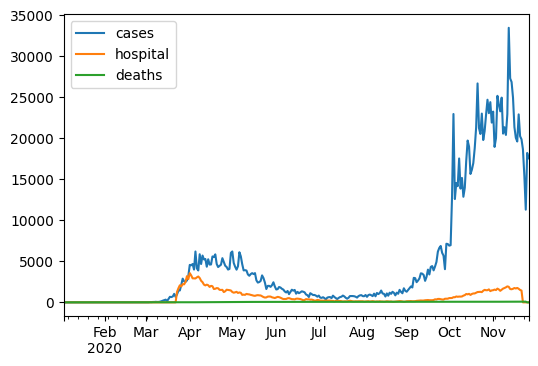

Output()

In [16]:
from uk_covid19 import Cov19API
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wdg

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

def createJson():
    filters = [
    'areaType=overview' ]
    structure = {
    "date": "date",
    "cases": "newCasesByPublishDate",
    "hospital": "newAdmissions",
    "deaths": "cumDeaths28DaysByDeathDateRate" }
    
    api = Cov19API(filters=filters, structure=structure)
    timeseries=api.get_json()

    with open("timeseries.json", "wt") as OUTF:
        json.dump(timeseries, OUTF)

def parse_date(datestring):
    return pd.to_datetime(datestring, format="%Y-%m-%d")

def createPkl():
    with open("timeseries.json", "rt") as INFILE:
        data=json.load(INFILE)

    datalist=data['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()

    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])
    

    index=pd.date_range(startdate, enddate, freq='D')
    timeseriesdf=pd.DataFrame(index=index, columns=['cases', 'hospital', 'deaths'])

    for entry in datalist:
        date=parse_date(entry['date'])
        for column in ['cases', 'hospital', 'deaths']:
            if pd.isna(timeseriesdf.loc[date, column]): 
                value= float(entry[column]) if entry[column]!=None else 0.0
                timeseriesdf.loc[date, column]=value
            

    timeseriesdf.fillna(0.0, inplace=True)
    timeseriesdf.to_pickle("timeseriesdf.pkl")

series=wdg.SelectMultiple(
    options=['cases', 'hospital', 'deaths'],
    value=['cases', 'hospital', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)

apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='', 
    tooltip='Click to download current Public Health England data',
    icon='download' 
)

controls = wdg.HBox([series, scale, apibutton])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

def access_api(button):
    createJson()
    createPkl()
    global timeseriesdf
    timeseriesdf=pd.read_pickle("timeseriesdf.pkl")
    
    current=scale.value
    if current==scale.options[0]:
        other=scale.options[1]
    else:
        other=scale.options[0]
    scale.value=other 
    scale.value=current 
    
apibutton.on_click(access_api)

createPkl()
timeseriesdf=pd.read_pickle("timeseriesdf.pkl")
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)
